In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [10]:
color_pal=sns.color_palette()
plt.style.use('fivethirtyeight')

In [11]:
df=pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv')
df=df.set_index('Datetime')
df.index=pd.to_datetime(df.index)

In [12]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [13]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB
None


In [14]:
print(df.describe())

             PJME_MW
count  145366.000000
mean    32080.222831
std      6464.012166
min     14544.000000
25%     27573.000000
50%     31421.000000
75%     35650.000000
max     62009.000000


In [15]:
print(type(df.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


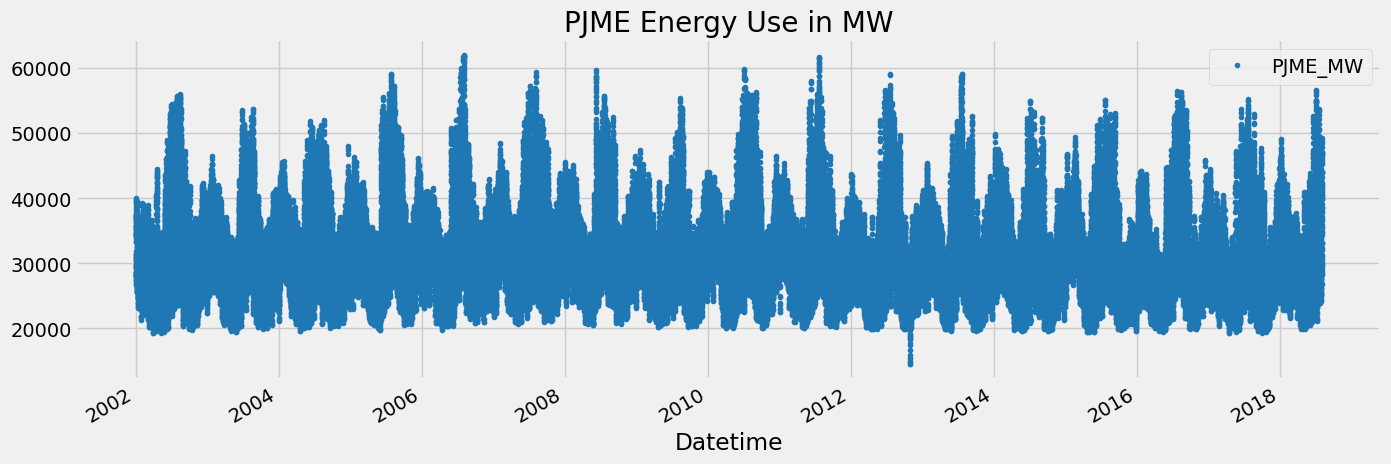

In [16]:
df.plot(
    style='.',
    figsize=(15,5),
    color=color_pal[0],
    title='PJME Energy Use in MW'
)
plt.show()

<Axes: ylabel='Frequency'>

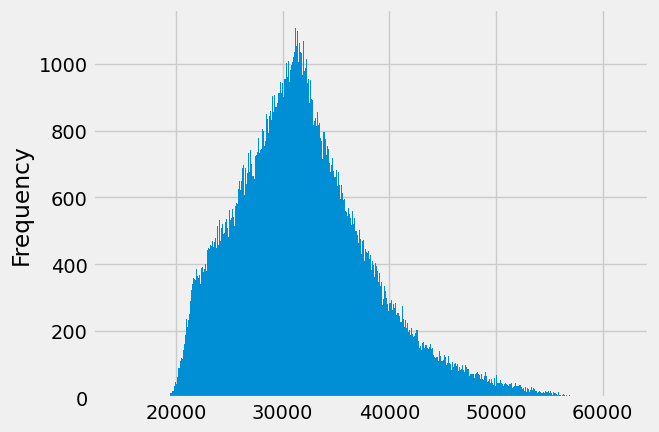

In [17]:
df['PJME_MW'].plot(kind='hist',bins=500)

<Axes: xlabel='Datetime'>

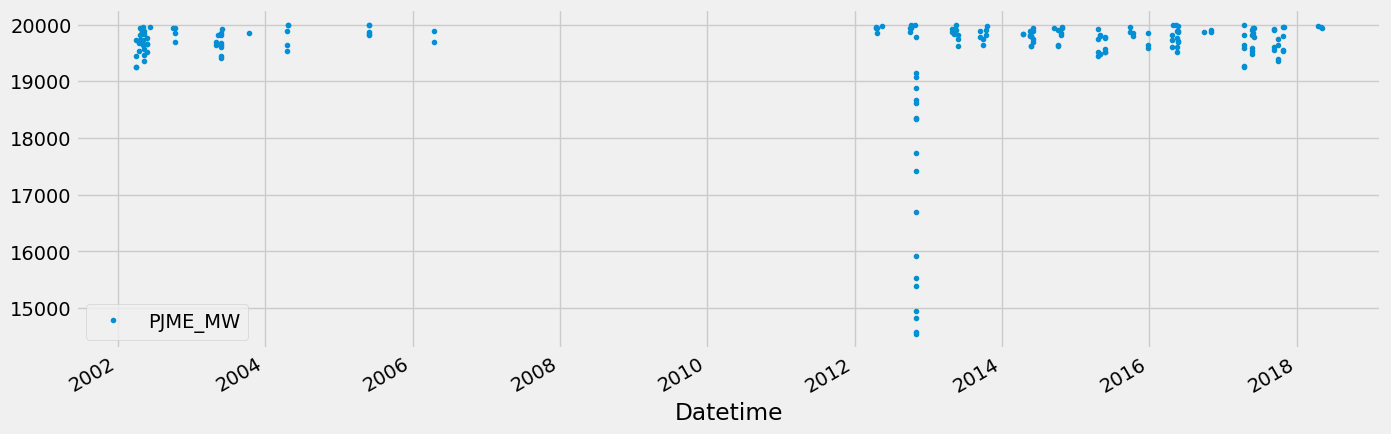

In [18]:
df.query('PJME_MW < 20_000').plot(figsize=(15,5),style='.')

In [19]:
df.query('PJME_MW < 20_000')

,PJME_MW
Datetime,
2002-10-13 04:00:00,19854.0
2002-10-13 05:00:00,19702.0
2002-10-13 06:00:00,19936.0
2002-09-29 05:00:00,19950.0
2002-06-09 06:00:00,19954.0
...,...
2017-04-15 04:00:00,19820.0
2017-04-15 05:00:00,19994.0
2018-05-06 05:00:00,19937.0


In [20]:
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
missing_timestamps = full_range.difference(df.index)

print(f"Number of missing timestamps: {len(missing_timestamps)}")

Number of missing timestamps: 30


/tmp/ipykernel_36/2511586281.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')


In [21]:
print("\nMissing values in PJME_MW column:", df['PJME_MW'].isna().sum())


Missing values in PJME_MW column: 0


In [22]:
df = df[~df.index.duplicated(keep='first')]

In [23]:
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

In [24]:
df = df.reindex(full_range)

In [25]:
df.index.name = 'Datetime'

In [26]:
df['PJME_MW'] = df['PJME_MW'].interpolate(method='time')

In [27]:
print("Missing values after cleaning:", df['PJME_MW'].isna().sum())


Missing values after cleaning: 0


/tmp/ipykernel_36/732469306.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


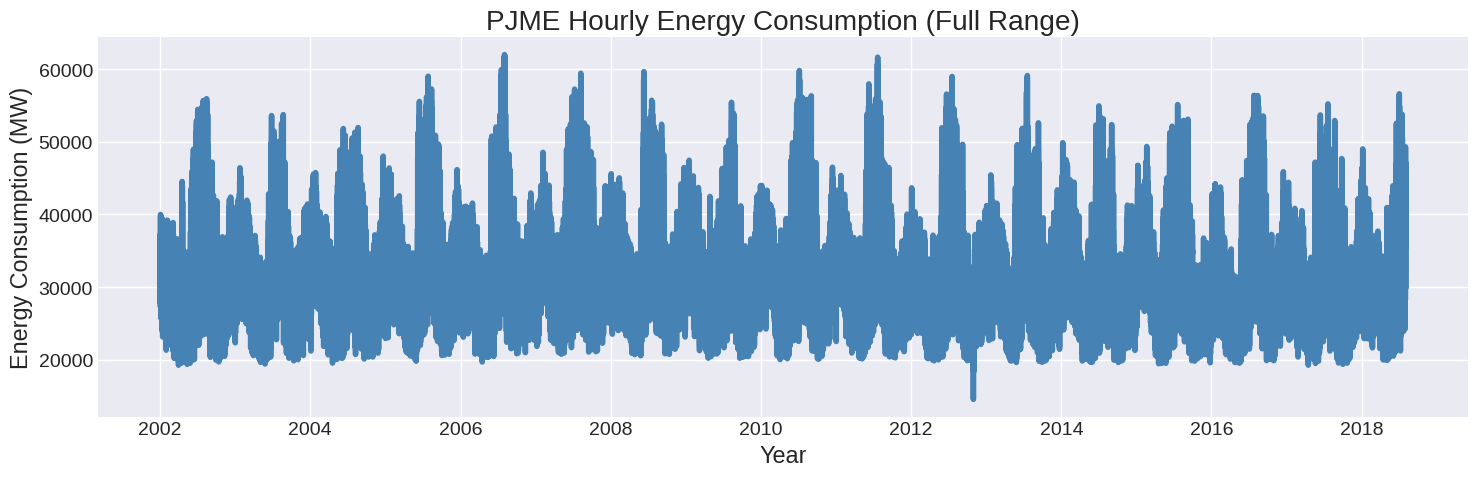

In [28]:

import matplotlib.pyplot as plt

# Set plotting style
plt.style.use('seaborn-darkgrid') 

plt.rcParams["figure.figsize"] = (15, 5)

# 1. Full Time Series Plot
plt.plot(df.index, df['PJME_MW'], color='steelblue')
plt.title('PJME Hourly Energy Consumption (Full Range)')
plt.xlabel('Year')
plt.ylabel('Energy Consumption (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
# Resample to daily average
daily_avg = df['PJME_MW'].resample('D').mean()

# Resample to weekly average
weekly_avg = df['PJME_MW'].resample('W').mean()

# Resample to monthly average
monthly_avg = df['PJME_MW'].resample('ME').mean()


/tmp/ipykernel_36/1444246851.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


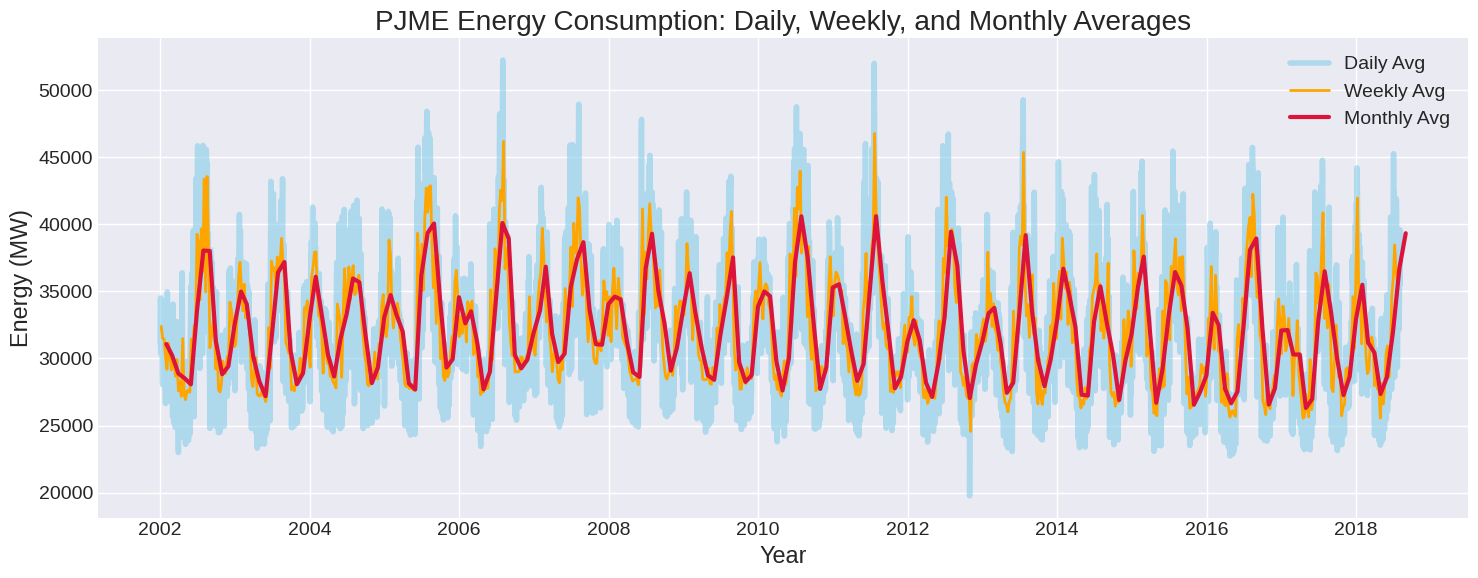

In [30]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(15, 6))

# Plot
plt.plot(daily_avg, label='Daily Avg', color='skyblue', alpha=0.6)
plt.plot(weekly_avg, label='Weekly Avg', color='orange', linewidth=2)
plt.plot(monthly_avg, label='Monthly Avg', color='crimson', linewidth=3)

plt.title('PJME Energy Consumption: Daily, Weekly, and Monthly Averages')
plt.xlabel('Year')
plt.ylabel('Energy (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_36/613855113.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


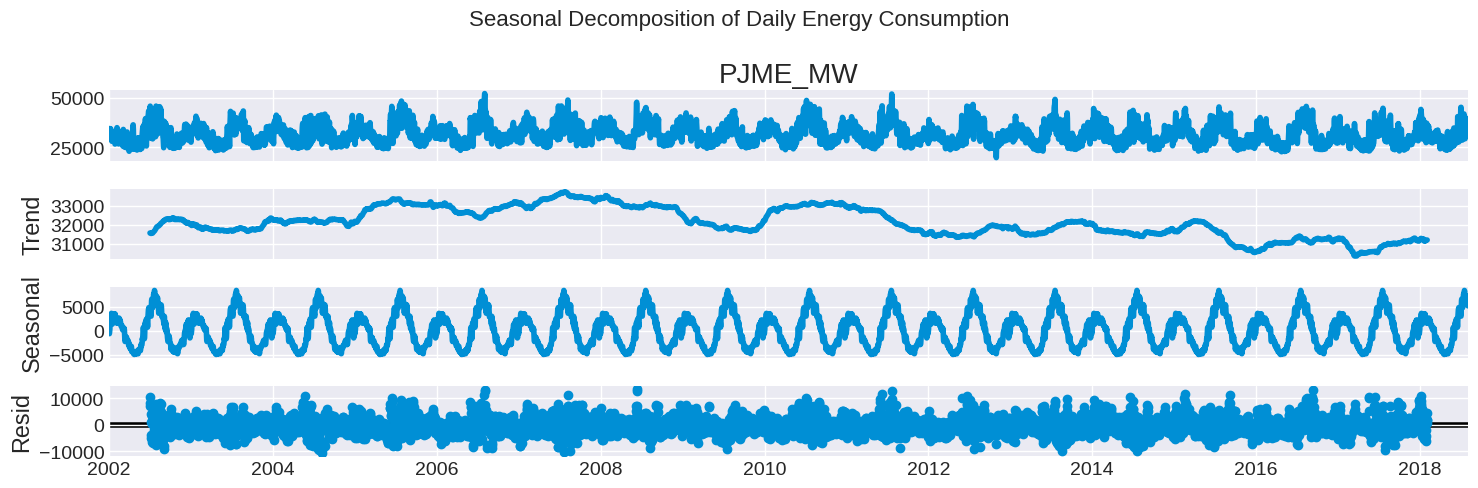

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Use daily data and drop NA values
daily_avg = df['PJME_MW'].resample('D').mean().dropna()

# Perform seasonal decomposition (additive model)
decomposition = seasonal_decompose(daily_avg, model='additive', period=365)

# Plot the decomposition
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Daily Energy Consumption', fontsize=16)
plt.tight_layout()
plt.show()


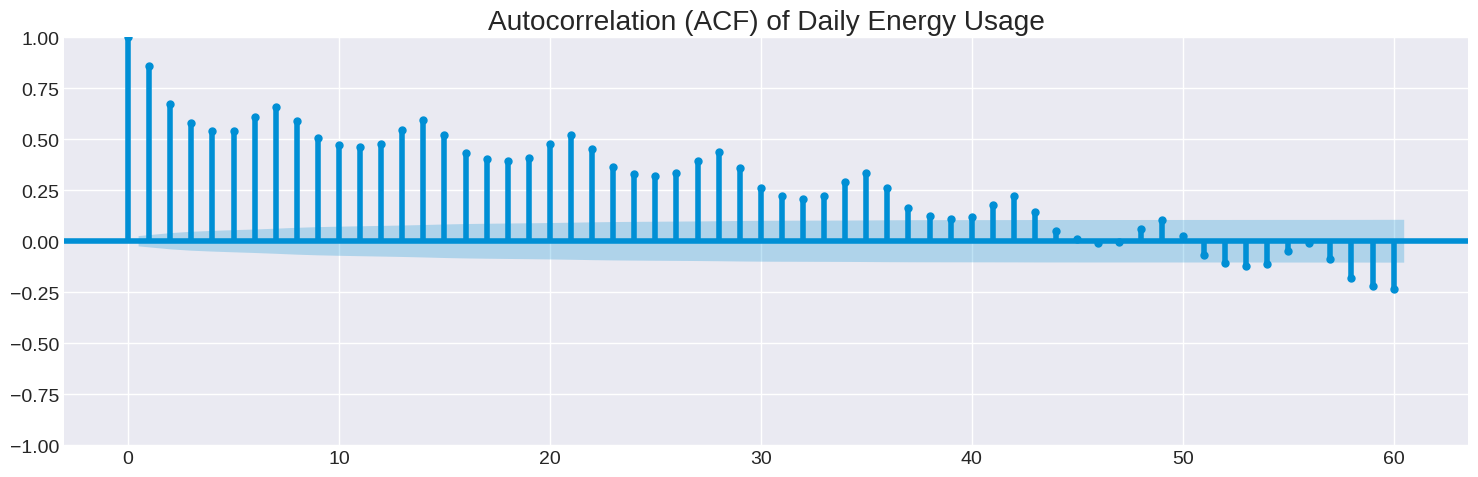

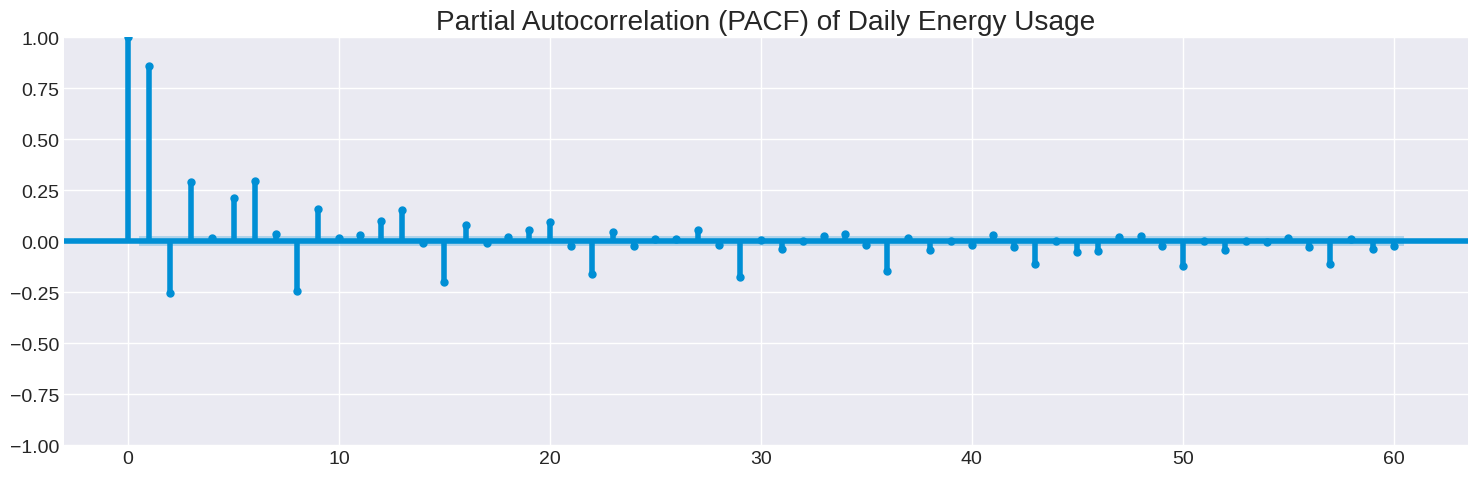

In [32]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Use daily averages to reduce noise
daily_avg = df['PJME_MW'].resample('D').mean().dropna()

# Plot ACF (up to 60 lags → about 2 months)
plot_acf(daily_avg, lags=60)
plt.title("Autocorrelation (ACF) of Daily Energy Usage")
plt.tight_layout()
plt.show()

# Plot PACF
plot_pacf(daily_avg, lags=60, method='ywm')  # 'ywm' is stable method
plt.title("Partial Autocorrelation (PACF) of Daily Energy Usage")
plt.tight_layout()
plt.show()


In [33]:
from statsmodels.tsa.stattools import adfuller


result = adfuller(df.dropna())

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

if result[1] < 0.05:
    print("Result: The time series is stationary (reject H0)")
else:
    print("Result: The time series is non-stationary (fail to reject H0)")


ADF Statistic: -19.96406401202099
p-value: 0.0
Critical Values:
   1%: -3.4303950013454645
   5%: -2.8615598899580115
   10%: -2.5667805867167433
Result: The time series is stationary (reject H0)


The null hypothesis (H0) of the ADF test is that the time series has a unit root (non-stationary).

If the p-value is less than 0.05, you reject the null hypothesis, meaning your time series is stationary.

Otherwise, it's non-stationary, and you might want to difference it or transform it to make it stationary.

In [34]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.3 MB/s eta 0:00:00a 0:00:01


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

series = df

# Use auto_arima to find best p, d, q
# Since stationarity is confirmed, set d=0
auto_model = auto_arima(series, start_p=0, max_p=5, start_q=0, max_q=5, 
                        seasonal=False, d=0, trace=True, error_action='ignore', 
                        suppress_warnings=True, stepwise=True)

print(f'Best model: {auto_model.summary()}')




Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3435555.374, Time=0.99 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=1.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=13.94 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2394099.697, Time=10.85 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2320327.521, Time=5.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2357140.985, Time=1.49 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2318382.458, Time=48.26 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=2.58 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=2318090.503, Time=46.46 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=3.15 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=2296994.243, Time=84.02 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=3.80 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=99.60 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=

In [50]:
# Split last 24 hours for testing
train = series[:-24]
test = series[-24:]

# Fit on training
model = ARIMA(train, order=best_order ,trend='c')
model_fit = model.fit()

print(model_fit.summary)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<bound method SARIMAXResults.summary of <statsmodels.tsa.arima.model.ARIMAResults object at 0x7d1ff76dd0d0>>


In [51]:
# Forecast next 24 hours
forecast = model_fit.forecast(steps=24)


In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)
mape = (abs((test - forecast) / test).mean()) * 100

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')



MAE: 3369.17
RMSE: 4164.91


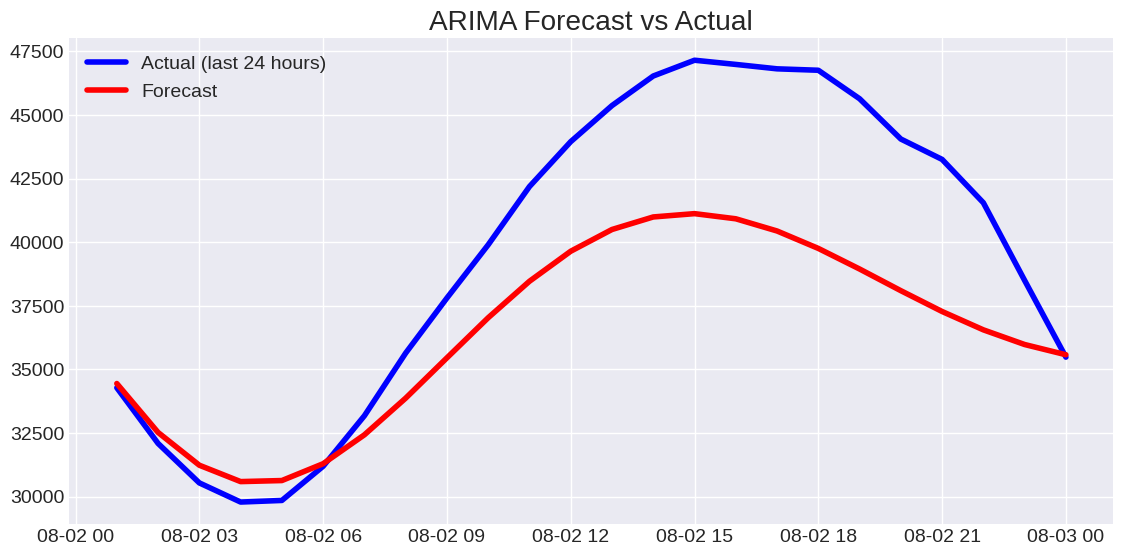

In [53]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Actual (last 24 hours)', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()


In [49]:
# model_fit.plot_diagnostics(figsize=(12, 8))
# plt.show()


In [36]:
# Fit the best ARIMA model 
best_order = auto_model.order
model = ARIMA(series, order=best_order)
model_fit = model.fit()
print(model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                PJME_MW   No. Observations:               145392
Model:                 ARIMA(5, 0, 1)   Log Likelihood            -1148350.943
Date:                Wed, 16 Jul 2025   AIC                        2296717.886
Time:                        23:12:16   BIC                        2296796.984
Sample:                    01-01-2002   HQIC                       2296741.494
                         - 08-03-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.208e+04    321.596     99.749      0.000    3.14e+04    3.27e+04
ar.L1          3.0797      0.002   1346.015      0.000       3.075       3.084
ar.L2         -3.7938      0.006   -633.213      0.0

In [37]:
#Forecast next 24 hours 
forecast_steps = 24
forecast = model_fit.forecast(steps=forecast_steps)
print(forecast)

2018-08-03 01:00:00    33426.538066
2018-08-03 02:00:00    32264.427315
2018-08-03 03:00:00    31738.599815
2018-08-03 04:00:00    31774.812083
2018-08-03 05:00:00    32364.602904
2018-08-03 06:00:00    33418.083064
2018-08-03 07:00:00    34773.752799
2018-08-03 08:00:00    36263.188621
2018-08-03 09:00:00    37741.023313
2018-08-03 10:00:00    39085.338715
2018-08-03 11:00:00    40197.679144
2018-08-03 12:00:00    41009.170689
2018-08-03 13:00:00    41485.228076
2018-08-03 14:00:00    41624.746264
2018-08-03 15:00:00    41455.376959
2018-08-03 16:00:00    41027.258460
2018-08-03 17:00:00    40406.086931
2018-08-03 18:00:00    39665.773802
2018-08-03 19:00:00    38881.184760
2018-08-03 20:00:00    38121.646863
2018-08-03 21:00:00    37445.757950
2018-08-03 22:00:00    36897.772913
2018-08-03 23:00:00    36505.650186
2018-08-04 00:00:00    36280.710588
Freq: h, Name: predicted_mean, dtype: float64


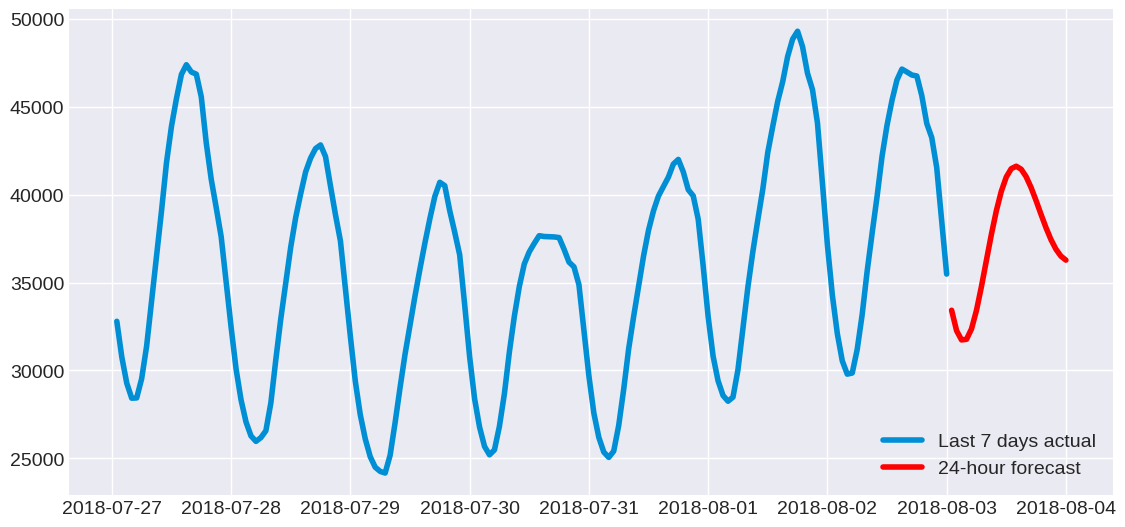

In [38]:
plt.figure(figsize=(12,6))
plt.plot(series[-7*24:], label='Last 7 days actual')
plt.plot(forecast.index, forecast, label='24-hour forecast', color='red')
plt.legend()
plt.show()